# **Prediction Algorithm with the use of Synthetic Data**

---

# **Table of Contents**

**Notebook Outline**

**Section 1: Problem Formulation**

**Section 2: Imports and Installs**

**Section 3: Data Load in**

**Section 4: Initial Exploration**

**Section 5: Target Variable Exploration**

**Section 6: Pre-Processing**

> **6.1:** Renaming

> **6.2:** Encoding Categorical Variables

> **6.3:** Missing Values

**Section 7: Synthetic Data Creation**

> **7.1:** Creation

> **7.2:** Correctness of Synthetic Data

> **7.3:** Further Syntehtic Data Inspection and Merging

**Section 8: ML Algorithm Synthetic Data**

**Section 9: Bias**

**Section 10: Final DataFrame**

**Section 11: Analysis**

**Section 12: Training Initial Models**

**Section 13: Final Model Evaluation**

**Section 14: Conclusion and Results**

---

# **Notebook Outline**

This notebook will begin with an exploratory analysis, which identifies many problems in the dataset. Namely bias and a significant number of NaN values.

I then procede to address the problems of bias and NaN values through the use of creatin synthetic data to update NaN values in the original dataframe. This keeps the original (correct) values, and updates NaN values with synthetic data which has an accuracy of ~0.77.

I then address the bias problem by generating more ML synthetic data which can be used to balance the target variable counts.

Then, a final dataframe is constructed, dropping a small number of NaN values. This final dataframe is fed into an SVC calssifation algorithm.

Finally, the model results are evaluated

---

# **Section 1: Problem Formulation**

- Import the data and do initial exploratory data analysis.  What observations can you make?
- Build either a Random Forest or a Support Vector Machine model to predict the Status.  Do NOT build both models and do NOT produce a deep learning or neural network model.
- Construct a confusion matrix and calculate performance metrics, eg accuracy etc.  Do you achieve similar results to Jennings as shown on page 7 of the attached paper?

---

# **Section 2: Imports and Installs**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from numpy import array
from scipy import stats
from scipy.stats import zscore

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

pd.options.mode.chained_assignment = None 
sns.set_style("darkgrid")
%matplotlib inline

!pip install sdv
from sdv.tabular import GaussianCopula

---

# **Section 3: Data Load In**

In [2]:
df0 = pd.read_csv('cell_phone_data.csv')  # Create checkpoint for original dataframe
df = pd.read_csv('cell_phone_data.csv')  # Create checkpoint for dataframe to be processed

print(df0.shape)
df0.head()

(7051, 32)


,Unnamed: 0,brand,phone,Status,release_year,release_quarter,headphone_jacks,composer,MP3,monophonic,...,Push_Email,Thread,Radio,Resolution,Screen_size,talk_time,weight_in_g,Keyboard,Primary,Secondary
0,1,Acer,Iconia A1-830,Available,2014.0,Q1,Yes,No,Yes,No,...,Yes,No,No,212,7.9,450.0,380.0,None,5.0,2.0
1,2,Acer,Iconia B1-720,Available,2014.0,Q1,Yes,No,Yes,No,...,Yes,No,No,188,7.0,300.0,315.0,None,0.3,0.0
2,3,Acer,Iconia B1-721,Available,2014.0,Q1,Yes,No,Yes,No,...,Yes,No,No,188,7.0,0.0,323.0,None,0.3,0.0
3,4,Acer,Iconia One 7 B1-730,Available,2014.0,Q2,Yes,No,Yes,No,...,Yes,No,No,770,7.0,420.0,0.0,None,5.0,0.0
4,5,Acer,Iconia Tab 7 A1-713,Available,2014.0,Q3,Yes,No,Yes,No,...,Yes,Yes,No,188,7.0,360.0,298.0,None,2.0,0.0


In [3]:
cols = df.columns  # Check the number of categorical columns
num_cols = df._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
len(cat_cols)

24

---

# **Section 4: Initial Exploration**

In [4]:
df.isna().sum()  # There are some NaN value issues that need to be addresed

Unnamed: 0            0
brand                 0
phone                 0
Status                0
release_year       3294
release_quarter    3615
headphone_jacks      67
composer              0
MP3                   0
monophonic            0
polyphonic            0
wav                   0
vibration             0
acc                   0
bluetooth            19
browser_type          0
GPS                   0
Java                  0
SMS                   0
MMS                   0
IM                    0
Email                 0
Push_Email            0
Thread                0
Radio                78
Resolution            0
Screen_size           0
talk_time            33
weight_in_g           0
Keyboard              0
Primary               0
Secondary             0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7051 entries, 0 to 7050
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       7051 non-null   int64  
 1   brand            7051 non-null   object 
 2   phone            7051 non-null   object 
 3   Status           7051 non-null   object 
 4   release_year     3757 non-null   float64
 5   release_quarter  3436 non-null   object 
 6   headphone_jacks  6984 non-null   object 
 7   composer         7051 non-null   object 
 8   MP3              7051 non-null   object 
 9   monophonic       7051 non-null   object 
 10  polyphonic       7051 non-null   object 
 11  wav              7051 non-null   object 
 12  vibration        7051 non-null   object 
 13  acc              7051 non-null   object 
 14  bluetooth        7032 non-null   object 
 15  browser_type     7051 non-null   object 
 16  GPS              7051 non-null   object 
 17  Java          

In [6]:
df.columns

Index(['Unnamed: 0', 'brand', 'phone', 'Status', 'release_year',
       'release_quarter', 'headphone_jacks', 'composer', 'MP3', 'monophonic',
       'polyphonic', 'wav', 'vibration', 'acc', 'bluetooth', 'browser_type',
       'GPS', 'Java', 'SMS', 'MMS', 'IM', 'Email', 'Push_Email', 'Thread',
       'Radio', 'Resolution', 'Screen_size', 'talk_time', 'weight_in_g',
       'Keyboard', 'Primary', 'Secondary'],
      dtype='object')

In [7]:
for col in df:  # This can be seen quite clearly when using VSCode
  print(df[col].head(0))
  print(df[col].unique())
  print('\n')

Series([], Name: Unnamed: 0, dtype: int64)
[   1    2    3 ... 7049 7050 7051]


Series([], Name: brand, dtype: object)
['Acer' 'Alcatel' 'Allview' 'Amazo' 'Amoi' 'Appl' 'Archo' 'Asu' 'AT&T'
 'Benefo' 'BenQ' 'BenQ-Siemen' 'Bird' 'BlackBerry' 'BLU' 'Bosc' 'Casi'
 'Cat' 'Celko' 'Chea' 'Dell' 'Emporia' 'Ericsso' 'Ete' 'Fujitsu Siemen'
 'Garmin-Asu' 'Gigabyt' 'Gione' 'Haier' 'HP' 'HTC' 'Huawei' 'i-mat'
 'i-mobil' 'Icemobil' 'Innostream' 'iNQ' 'Jolla' 'Karbon' 'Kyocera' 'Lava'
 'Lenov' 'LG' 'Maxo' 'Maxwest' 'Meizu' 'Micromax' 'Microsoft' 'Mitac'
 'Mitsubishi' 'Modu' 'Motorola' 'MWg' 'NEC' 'Neonod' 'NIU' 'Nokia'
 'Nvidia' 'O2' 'OnePlu' 'Opp' 'Orang' 'Palm' 'Panasonic' 'Pantec' 'Parla'
 'Philip' 'Plum' 'Prestigi' 'Qtek' 'Sagem' 'Samsung' 'Send' 'Sewo' 'Shar'
 'Siemen' 'Sonim' 'Sony' 'Sony Ericsso' 'Spic' 'T-Mobil' 'Tel.Me.' 'Telit'
 'Thuraya' 'Toshiba' 'Unnect' 'Vertu' 'verykool' 'viv' 'VK Mobil'
 'Vodafon' 'Wik' 'WND' 'XCut' 'Xiaomi' 'XOLO' 'Yezz' 'Yota' 'YU' 'ZTE']


Series([], Name: phone,

---

# **Section 5: Target Variable Exploration**

In [8]:
df.Status.unique()

array(['Available', 'Discontinued'], dtype=object)

In [9]:
df.Status.value_counts()  # There appears to be around 75% bias

Available       4030
Discontinued    3021
Name: Status, dtype: int64

I am currently in the process of learning how to use a machine learning algorithm to learn from the input data and produce synthetic data that correctly alligns with correlation. I would use this to balance the dataset to reduce bias.

In [10]:
cols = list(df.columns.values) # Pop target variables to the last column (ease of use)
cols.pop(cols.index('Status'))
df = df[cols+['Status']]
df.head()

,Unnamed: 0,brand,phone,release_year,release_quarter,headphone_jacks,composer,MP3,monophonic,polyphonic,...,Thread,Radio,Resolution,Screen_size,talk_time,weight_in_g,Keyboard,Primary,Secondary,Status
0,1,Acer,Iconia A1-830,2014.0,Q1,Yes,No,Yes,No,No,...,No,No,212,7.9,450.0,380.0,None,5.0,2.0,Available
1,2,Acer,Iconia B1-720,2014.0,Q1,Yes,No,Yes,No,No,...,No,No,188,7.0,300.0,315.0,None,0.3,0.0,Available
2,3,Acer,Iconia B1-721,2014.0,Q1,Yes,No,Yes,No,No,...,No,No,188,7.0,0.0,323.0,None,0.3,0.0,Available
3,4,Acer,Iconia One 7 B1-730,2014.0,Q2,Yes,No,Yes,No,No,...,No,No,770,7.0,420.0,0.0,None,5.0,0.0,Available
4,5,Acer,Iconia Tab 7 A1-713,2014.0,Q3,Yes,No,Yes,No,No,...,Yes,No,188,7.0,360.0,298.0,None,2.0,0.0,Available


---

# **Section 6: Pre-Processing**

### **6.1: Renaming**

In [11]:
df = df.rename(columns={"Unnamed: 0": "label"})  # Rename the first column as 'label'
df

,label,brand,phone,release_year,release_quarter,headphone_jacks,composer,MP3,monophonic,polyphonic,...,Thread,Radio,Resolution,Screen_size,talk_time,weight_in_g,Keyboard,Primary,Secondary,Status
0,1,Acer,Iconia A1-830,2014.0,Q1,Yes,No,Yes,No,No,...,No,No,212,7.9,450.0,380.0,None,5.0,2.0,Available
1,2,Acer,Iconia B1-720,2014.0,Q1,Yes,No,Yes,No,No,...,No,No,188,7.0,300.0,315.0,None,0.3,0.0,Available
2,3,Acer,Iconia B1-721,2014.0,Q1,Yes,No,Yes,No,No,...,No,No,188,7.0,0.0,323.0,None,0.3,0.0,Available
3,4,Acer,Iconia One 7 B1-730,2014.0,Q2,Yes,No,Yes,No,No,...,No,No,770,7.0,420.0,0.0,None,5.0,0.0,Available
4,5,Acer,Iconia Tab 7 A1-713,2014.0,Q3,Yes,No,Yes,No,No,...,Yes,No,188,7.0,360.0,298.0,None,2.0,0.0,Available
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7046,7047,ZTE,Salute F350,2010.0,Q3,No,No,Yes,No,No,...,No,No,1496,2.4,240.0,112.0,None,1.3,0.0,Available
7047,7048,ZTE,X760,NaN,NaN,No,No,Yes,No,No,...,No,Yes,1496,2.4,180.0,84.0,None,1.3,0.0,Discontinued
7048,7049,ZTE,X990,2010.0,Q1,No,No,Yes,No,No,...,No,Yes,1444,2.5,480.0,90.0,QWERTY,2.0,0.0,Available
7049,7050,ZTE,X990D,2010.0,NaN,No,No,Yes,No,No,...,No,Yes,1444,2.5,0.0,90.0,QWERTY,2.0,0.0,Available


---

### **6.2: Encoding Categorical Variables**

In [12]:
def encode(df, col):  # Encode categorical values
    
    store = []
    
    for i in range(0,len(cat_columns),1):
        
        df[col[i]] = df[col[i]].astype('category').cat.codes
        store.append(df[col[i]])
    
    return store

cat_columns = cat_cols


x = encode(df, cat_columns)
df['Keyboard'] = df.Keyboard.astype('category').cat.codes
df

,label,brand,phone,release_year,release_quarter,headphone_jacks,composer,MP3,monophonic,polyphonic,...,Thread,Radio,Resolution,Screen_size,talk_time,weight_in_g,Keyboard,Primary,Secondary,Status
0,1,1,2794,2014.0,0,1,0,1,0,0,...,0,0,212,7.9,450.0,380.0,1,5.0,2.0,0
1,2,1,2795,2014.0,0,1,0,1,0,0,...,0,0,188,7.0,300.0,315.0,1,0.3,0.0,0
2,3,1,2796,2014.0,0,1,0,1,0,0,...,0,0,188,7.0,0.0,323.0,1,0.3,0.0,0
3,4,1,2797,2014.0,1,1,0,1,0,0,...,0,0,770,7.0,420.0,0.0,1,5.0,0.0,0
4,5,1,2799,2014.0,2,1,0,1,0,0,...,1,0,188,7.0,360.0,298.0,1,2.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7046,7047,94,5048,2010.0,2,0,0,1,0,0,...,0,0,1496,2.4,240.0,112.0,1,1.3,0.0,0
7047,7048,94,6143,NaN,-1,0,0,1,0,0,...,0,1,1496,2.4,180.0,84.0,1,1.3,0.0,1
7048,7049,94,6155,2010.0,0,0,0,1,0,0,...,0,1,1444,2.5,480.0,90.0,2,2.0,0.0,0
7049,7050,94,6156,2010.0,-1,0,0,1,0,0,...,0,1,1444,2.5,0.0,90.0,2,2.0,0.0,0


In [13]:
df['release_quarter'] = df.release_quarter.replace({-1: np.NaN, 0:1, 1:2, 2:3, 3:4})  # An error led to me hard coding the values for release_quarter
df['Status'] = df.Status.replace({0: 1, 1:0})  # Here I changed discontinued (1) to (0), to improve interpretibility

df.Status.value_counts()

# The error was that the algorithm returned 5 values, when there are only 4 quarter, and counted Q0 instead of Q1

1    4030
0    3021
Name: Status, dtype: int64

In [14]:
print(df0.release_quarter.isna().sum())  # Check the correction has worked
print(df.release_quarter.value_counts())

3615
3.0    989
4.0    936
2.0    872
1.0    639
Name: release_quarter, dtype: int64


In [15]:
print(len(df0.phone.unique()))  # Superficial check, but quick!
df.phone.describe() 

6767


count    7051.000000
mean     3379.953056
std      1963.045142
min         0.000000
25%      1670.500000
50%      3381.000000
75%      5089.500000
max      6766.000000
Name: phone, dtype: float64

As there are 6767 unique values for the phone column in the original dataframe, the encoded dataframe phone column having a max number of 6766 (+1 for row 0), I am satisfied this has been implemented correctly.

---

### **6.3: Missing Values**

In [16]:
df.columns

Index(['label', 'brand', 'phone', 'release_year', 'release_quarter',
       'headphone_jacks', 'composer', 'MP3', 'monophonic', 'polyphonic', 'wav',
       'vibration', 'acc', 'bluetooth', 'browser_type', 'GPS', 'Java', 'SMS',
       'MMS', 'IM', 'Email', 'Push_Email', 'Thread', 'Radio', 'Resolution',
       'Screen_size', 'talk_time', 'weight_in_g', 'Keyboard', 'Primary',
       'Secondary', 'Status'],
      dtype='object')

In [17]:
df = df.drop(['acc'], axis = 1)  # 'acc' only has one value, 'no', so serves no purpose
df.head()

,label,brand,phone,release_year,release_quarter,headphone_jacks,composer,MP3,monophonic,polyphonic,...,Thread,Radio,Resolution,Screen_size,talk_time,weight_in_g,Keyboard,Primary,Secondary,Status
0,1,1,2794,2014.0,1.0,1,0,1,0,0,...,0,0,212,7.9,450.0,380.0,1,5.0,2.0,1
1,2,1,2795,2014.0,1.0,1,0,1,0,0,...,0,0,188,7.0,300.0,315.0,1,0.3,0.0,1
2,3,1,2796,2014.0,1.0,1,0,1,0,0,...,0,0,188,7.0,0.0,323.0,1,0.3,0.0,1
3,4,1,2797,2014.0,2.0,1,0,1,0,0,...,0,0,770,7.0,420.0,0.0,1,5.0,0.0,1
4,5,1,2799,2014.0,3.0,1,0,1,0,0,...,1,0,188,7.0,360.0,298.0,1,2.0,0.0,1


In [18]:
print(df.release_year.isna().sum())  # There are a significant number of NaN values in these two features 
print(df.release_quarter.isna().sum())  

3294
3615


---

# **Section 7: Synthetic Data Creation**

The end goal for this section is to use a machine learning algorithm to create synthetic data to replace NaN values.

If we fed the original dataframe to the algorithm, it would learn and produce NaN values.

To use the algorithm correctly, we will create our own synthetic data, which will be used to train the model to output a more accurate form of synthetic data. 

The more accurate form of synthetic data will be used to replace NaN values, improving overall accuracy of final model.

---

### **7.1: Creation**

In [19]:
dfs = df  # Create check point
dfs

,label,brand,phone,release_year,release_quarter,headphone_jacks,composer,MP3,monophonic,polyphonic,...,Thread,Radio,Resolution,Screen_size,talk_time,weight_in_g,Keyboard,Primary,Secondary,Status
0,1,1,2794,2014.0,1.0,1,0,1,0,0,...,0,0,212,7.9,450.0,380.0,1,5.0,2.0,1
1,2,1,2795,2014.0,1.0,1,0,1,0,0,...,0,0,188,7.0,300.0,315.0,1,0.3,0.0,1
2,3,1,2796,2014.0,1.0,1,0,1,0,0,...,0,0,188,7.0,0.0,323.0,1,0.3,0.0,1
3,4,1,2797,2014.0,2.0,1,0,1,0,0,...,0,0,770,7.0,420.0,0.0,1,5.0,0.0,1
4,5,1,2799,2014.0,3.0,1,0,1,0,0,...,1,0,188,7.0,360.0,298.0,1,2.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7046,7047,94,5048,2010.0,3.0,0,0,1,0,0,...,0,0,1496,2.4,240.0,112.0,1,1.3,0.0,1
7047,7048,94,6143,NaN,NaN,0,0,1,0,0,...,0,1,1496,2.4,180.0,84.0,1,1.3,0.0,0
7048,7049,94,6155,2010.0,1.0,0,0,1,0,0,...,0,1,1444,2.5,480.0,90.0,2,2.0,0.0,1
7049,7050,94,6156,2010.0,NaN,0,0,1,0,0,...,0,1,1444,2.5,0.0,90.0,2,2.0,0.0,1


In [20]:
ry_na_count = df0.release_year.isna().sum()  # Release year NaN values
ry_val_count = df0.release_year.value_counts().sum()  # Release year NaN counts sum

rq_na_count = df.release_year.isna().sum()  # Release year NaN values
rq_val_count = df.release_year.value_counts().sum()  # Release year NaN counts sum

In [21]:
def get_weight(df, col):
    """
    get_weight - Get the percent (weight) of unique values

    Args:
        df: Dataframe to use
        col: Columns to use

    Returns:
        Unique value weights
    """    
    query = df[col[0]]
    counts = query.value_counts().to_numpy()
    
    weights = []
    stop = len(counts)
    
    for i in range(0,stop,1):
        weight = counts[i]/counts.sum()
        weights.append(weight)
    return weights

In [22]:
def synth(df, col, weights, names):
    """
    synth - Synthesis data

    Args:
        df: Dataframe to use
        col: Column to use
        weights: Weighting of unique value
        names: Unique value label

    Returns:
        Synthetic data
    """    
    store = []
    stop = len(names)
    
    for i in range(0,stop,1):
        dfs = df.sample(frac=weights[i])
        dfs = dfs[col[0]].fillna(names[i])
        dfs = pd.DataFrame(dfs)
        store.append(dfs)
    return pd.concat(store)

In [23]:
col = ['release_year']  # This cell is tasked with passing 'release year' through the above functions to produce synthetic data
year_weights = get_weight(dfs,col)
year_weights = array(year_weights)
year_names = df0.release_year.value_counts().index

synth_data = synth(dfs, col, year_weights, year_names)
synth_year = synth_data.sort_index()

In [24]:
col = ['release_quarter']  # This cell is tasked with passing 'release quarter' through the above functions to produce synthetic data
q_weights = get_weight(dfs,col)
q_weights = array(q_weights)
q_names = df.release_quarter.value_counts().index

synth_q = synth(dfs, col, q_weights, q_names)
synth_q = synth_q.sort_index()

In [25]:
display(synth_q)   # Here we can see the results of our initial data synthesis
display(synth_year)

,release_quarter
1,1.0
3,2.0
4,3.0
9,4.0
9,4.0
...,...
7043,3.0
7044,4.0
7047,3.0
7048,1.0


,release_year
3,2014.0
4,2014.0
5,2014.0
6,2014.0
7,2013.0
...,...
7047,2010.0
7048,2010.0
7049,2010.0
7049,2010.0


---

### **7.2: Correctness of Synthetic Data**

In [26]:
ry_sum = df0.release_year.value_counts()  # Sum of original release year values
ry_synth_sum = synth_year.value_counts()  # Sum of synth release year values

rq_sum = df.release_quarter.value_counts()
rq_synth_sum = synth_q.value_counts()

In [27]:
ry_val_count/len(df0)  # Proportion of non-nan values for release year in original dataframe

0.5328322223798043

In [28]:
rq_val_count/len(df0)  # Proportion of non-nan values for release quarter in original dataframe

0.5328322223798043

In [29]:
print(ry_sum, '\n') 
print(round(ry_synth_sum*0.5328322223798043,0))

print('------------------------------')

print(rq_sum, '\n')
print(round(rq_synth_sum*0.5328322223798043,0))

2014.0    857
2013.0    773
2012.0    635
2010.0    532
2011.0    526
2009.0    246
2015.0    188
Name: release_year, dtype: int64 

release_year
2014.0          886.0
2013.0          729.0
2012.0          634.0
2010.0          541.0
2011.0          534.0
2009.0          248.0
2015.0          186.0
dtype: float64
------------------------------
3.0    989
4.0    936
2.0    872
1.0    639
Name: release_quarter, dtype: int64 

release_quarter
3.0                1083.0
4.0                1005.0
2.0                 949.0
1.0                 720.0
dtype: float64


In [30]:
ry_sum = ry_sum.to_numpy()
ry_synth_sum = ry_synth_sum.to_numpy()

rq_sum = rq_sum.to_numpy()
rq_synth_sum = rq_synth_sum.to_numpy()

In [31]:
x = ry_synth_sum[1]/ry_synth_sum.sum()
y = ry_sum[1]/ry_sum.sum()
print('',round(x,5),'\n',round(y,5))
print('The data is representative with accuracy:', round(y/x,4), 'meaning the synthetic release year data is slightly over representing the real values, as seen above\n')

x = rq_synth_sum[1]/rq_synth_sum.sum()
y = rq_sum[1]/rq_sum.sum()
print('',round(x,5),'\n',round(y,5))
print('The data is representative with accuracy:', round(y/x,4), 'meaning the synthetic release quarter data is slightly over representing the real values, as seen above')

 0.19402 
 0.20575
The data is representative with accuracy: 1.0605 meaning the synthetic release year data is slightly over representing the real values, as seen above

 0.26762 
 0.27241
The data is representative with accuracy: 1.0179 meaning the synthetic release quarter data is slightly over representing the real values, as seen above


#### The 'release_year' synthetic data is sufficiently representative of the original dataframes values. The 'release_quarter' synthetic data is sufficiently representative of the original dataframes values.

---

### **7.3: Further Syntehtic Data Inspection and Merging**

In this section, we pre-process our synthetic data ready to be used to fill NaN values of the original dataframe. We further inspect the synthesised data for correctness and in general check all is as it should be at this point. Meaning the number of NaN values have been updated and synthetic data has been implemented correctly.

In [32]:
synth_year = synth_year.reset_index()  # This cell is tasked with renaming and producing labels for later merging
synth_year = synth_year.rename(columns={'release_year':'synth_ry'})
synth_year = synth_year.rename(columns={'index':'label'})
print(synth_year.isna().sum())

label       0
synth_ry    0
dtype: int64


In [33]:
synth_q = synth_q.reset_index()  # This cell is tasked with renaming and producing labels for later merging
synth_q = synth_q.rename(columns={'release_quarter':'synth_rq'})
synth_q = synth_q.rename(columns={'index':'label'})
print(synth_q.isna().sum())

label       0
synth_rq    0
dtype: int64


In [34]:
synth_qx = synth_q.drop_duplicates()  # Drop duplicates of labels
synth_yx = synth_year.drop_duplicates()
len(synth_qx)

5980

In [35]:
x = df['release_year'].fillna(synth_yx['synth_ry']).to_numpy()
y = df['release_quarter'].fillna(synth_qx['synth_rq']).to_numpy()

In [36]:
synth_ry = pd.DataFrame(x, columns=['synth_ry'])  # Create dataframes of synth data
synth_rq = pd.DataFrame(y, columns=['synth_rq'])
print(synth_ry.value_counts(), '\n')
print(synth_rq.value_counts())

synth_ry
2014.0      1572
2013.0      1375
2012.0      1124
2011.0       952
2010.0       948
2009.0       422
2015.0       345
dtype: int64 

synth_rq
3.0         1967
4.0         1851
2.0         1717
1.0         1268
dtype: int64


In [37]:
dfs = dfs.combine_first(dfs[['release_quarter', 'label']].merge(synth_qx, on='label'))
dfs = dfs.combine_first(dfs[['release_year', 'label']].merge(synth_yx, on='label'))
dfs = dfs[0:7051]

In [38]:
dfs = dfs.fillna(dfs[['release_year', 'label']].merge(synth_yx, on='label', how='left'))
dfs = dfs.fillna(dfs[['release_quarter', 'label']].merge(synth_qx, on='label', how='left'))

In [39]:
dfs['compare'] = dfs['release_year'].ne(dfs['synth_ry'])
print('Correct number of values synthesised for release year:', dfs['compare'].sum())

dfs['compare'] = dfs['release_quarter'].ne(dfs['synth_rq'])
print('Correct number of values synthesised for release quarter:', dfs['compare'].sum())

print('This is roughly equal to:', round(dfs['compare'].sum()/len(dfs),4), '% correctness for both yearly and quarterly release')

Correct number of values synthesised for release year: 5387
Correct number of values synthesised for release quarter: 5426
This is roughly equal to: 0.7695 % correctness for both yearly and quarterly release


In [40]:
print(dfs.release_year.isna().sum())
print(dfs.release_quarter.isna().sum())

712
910


In [41]:
print(df0.release_year.isna().sum())
print(df0.release_quarter.isna().sum())

3294
3615


The synthetic data has reduced NaN values down from around 7000 to 1500. Again, this will be crucial for helping the machine learning algorithm produce more quality synthetic data.

The remaining NaN values will be dropped before being fed into the model.

---

# **Section 8: Machine Learning Algorithm Synthetic Data**

In [42]:
df_feed = dfs.dropna(subset = ['release_year', 'release_quarter'])
df_feed.head()


,Email,GPS,IM,Java,Keyboard,MMS,MP3,Primary,Push_Email,Radio,...,polyphonic,release_quarter,release_year,synth_rq,synth_ry,talk_time,vibration,wav,weight_in_g,compare
0,1,1,1,1,1,0,1,5.0,1,0,...,0,1.0,2014.0,1.0,2014.0,450.0,1,1,380.0,False
1,1,1,1,1,1,0,1,0.3,1,0,...,0,1.0,2014.0,2.0,2014.0,300.0,1,1,315.0,True
2,1,1,1,1,1,0,1,0.3,1,0,...,0,1.0,2014.0,3.0,2014.0,0.0,1,1,323.0,True
3,1,0,1,1,1,0,1,5.0,1,0,...,0,2.0,2014.0,4.0,2014.0,420.0,1,1,0.0,True
4,1,1,1,1,1,1,1,2.0,1,0,...,0,3.0,2014.0,4.0,2013.0,360.0,1,1,298.0,True


In [43]:
model = GaussianCopula()  # Define synthetic data model
model.fit(df_feed)

c:\Users\delst\anaconda3\lib\site-packages\copulas\univariate\truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
c:\Users\delst\anaconda3\lib\site-packages\copulas\univariate\truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale


In [44]:
sample_df = model.sample(20000)  # Create sample synthetic data using ML algorithm
sample_df = sample_df.sort_values(by='label')
sample_df.head()

,Email,GPS,IM,Java,Keyboard,MMS,MP3,Primary,Push_Email,Radio,...,polyphonic,release_quarter,release_year,synth_rq,synth_ry,talk_time,vibration,wav,weight_in_g,compare
6758,0,0,0,1,1,0,0,1.84,0,0,...,1,3.0,2013.0,3.0,2011.0,222.0,1,0,94.7,False
8607,0,1,0,0,1,0,1,0.74,0,0,...,0,3.0,2011.0,1.0,2014.0,75.0,1,1,221.2,False
401,1,0,1,1,1,1,1,4.89,0,1,...,0,3.0,2015.0,3.0,2013.0,465.0,1,1,84.2,True
5457,1,1,1,1,1,1,0,2.31,0,-1,...,1,3.0,2014.0,1.0,2013.0,166.0,1,1,183.4,True
15729,1,1,1,1,1,1,1,6.02,1,0,...,1,3.0,2013.0,3.0,2015.0,260.0,1,1,139.9,True


In [45]:
sample = sample_df.drop_duplicates(subset=['label'])

sample_y = sample.rename(columns={'release_year':'sample_ry'})
sample_q = sample.rename(columns={'release_quarter':'sample_rq'})

In [46]:
sample_y = sample_y[['label','sample_ry']]
sample_q = sample_q[['label','sample_rq']]
sample_y.head()

,label,sample_ry
6758,1,2013.0
401,2,2015.0
15729,3,2013.0
8682,4,2013.0
7696,5,2014.0


In [47]:
dfs = pd.merge(dfs, sample_y, on='label')
dfs = pd.merge(dfs, sample_q, on='label')

In [48]:
dfx = dfs.fillna(dfs[['release_year', 'label']].merge(sample_y, on='label'))
dfx = dfx.fillna(dfx[['release_quarter', 'label']].merge(sample_q, on='label'))
print(dfx.release_year.isna().sum())
print(dfx.release_quarter.isna().sum())

662
861


We have now replaced the remaining 1500 NaN values with machine learning synthetic data. There are still some NaN values remaining.

In [49]:
dfx['compare'] = dfx['release_year'].ne(dfx['sample_ry'])
print('Correct number of values synthesised for release year:', dfx['compare'].sum())

dfx['compare'] = dfx['release_quarter'].ne(dfx['sample_rq'])
print('Correct number of values synthesised for release quarter:', dfx['compare'].sum())

print('This is roughly equal to:', round(dfx['compare'].sum()/len(dfx),4), '% correctness for both yearly and quarterly release')

Correct number of values synthesised for release year: 5658
Correct number of values synthesised for release quarter: 5117
This is roughly equal to: 0.7731 % correctness for both yearly and quarterly release


##### As you can see, the algorithm has returned a dataframe of synthetic values that follow a similar relation to the original dataset. We could merge the original and synthetic dataframes to create more data, but for now, we will solve the problem of original NaN values in release year and quarter.

##### The remaining NaNs will be replaced with column modes. I made this decision based on the fact that the dataset is quite small, so dropping ~10% of the data is not desired. Furthermore, the dataset has 32 features, which if were to be dropped, would result in the loss of a significant amount of information, especially since all features correlate highly with the target variable (seen in confusion amtrix below).

In [50]:
for column in ['release_year', 'release_quarter']:
    dfx[column].fillna(dfx[column].mode()[0], inplace=True)

In [51]:
print(dfx.release_year.isna().sum())
print(dfx.release_quarter.isna().sum())

0
0


---

# **Section 9: Bias**

Synthetic data from the machine learning algorithm can be useful for more than just filling NaN values. It can be further reduced to reduce bias in the dataframe.

In [52]:
df_bias = sample_df  # This cell creates a checkpoint using the sample_df to adjust bias
dfb = df_bias.sort_values(by='label')

In [53]:
cols = list(dfb.columns.values) # Pop target variables to the last column
cols.pop(cols.index('label'))
dfb = dfb[cols+['label']]
dfb.head()

,Email,GPS,IM,Java,Keyboard,MMS,MP3,Primary,Push_Email,Radio,...,release_quarter,release_year,synth_rq,synth_ry,talk_time,vibration,wav,weight_in_g,compare,label
6758,0,0,0,1,1,0,0,1.84,0,0,...,3.0,2013.0,3.0,2011.0,222.0,1,0,94.7,False,1
8607,0,1,0,0,1,0,1,0.74,0,0,...,3.0,2011.0,1.0,2014.0,75.0,1,1,221.2,False,1
401,1,0,1,1,1,1,1,4.89,0,1,...,3.0,2015.0,3.0,2013.0,465.0,1,1,84.2,True,2
5457,1,1,1,1,1,1,0,2.31,0,-1,...,3.0,2014.0,1.0,2013.0,166.0,1,1,183.4,True,2
15729,1,1,1,1,1,1,1,6.02,1,0,...,3.0,2013.0,3.0,2015.0,260.0,1,1,139.9,True,3


In [54]:
required_rows = dfx.Status.value_counts()[0]-dfx.Status.value_counts()[1]  # Here we identify the level of bias we need to address

print(dfx.Status.value_counts(), '\n')
print('The current bias is:',  round(dfx.Status.value_counts()[1]/dfx.Status.value_counts()[0], 4))
print('We wish to create:', required_rows , 'synthetic rows')

1    3781
0    2838
Name: Status, dtype: int64 

The current bias is: 1.3323
We wish to create: -943 synthetic rows


In [55]:
x = dfb.sample(frac=1)  # Shuffle the dataframe so we do not get 

In [56]:
dfsub = x[x['Status'] == 1]  # Here we only get the rows containing the bias (Status=1) that we need to resolve the problem

In [57]:
start = len(dfx)  # This cell is tasked with created new labels for the data that will be used to resolve issue with bias
stop = start+len(dfsub)

create_labels = np.arange(start,stop,1)
bias_labels = pd.DataFrame(create_labels, columns=['labels'])
bias_labels = bias_labels[0:required_rows]
bias_labels.head()

,labels
0,6619
1,6620
2,6621
3,6622
4,6623


In [58]:
dfsub = dfsub[0:required_rows]  # This cell adds to the new labels to the new resolving bias dataframe
dfsub['label'] = bias_labels.to_numpy()

In [59]:
dfsub = dfsub.reset_index()  # Here we reset the index, so when we concat the dataframes, the index will be clean
dfsub = dfsub.drop(columns='index')

In [60]:
frames = [dfx, dfsub]  # Here we concat the dataframe containing synthetic data used to address the NaN issues, with the dataframe used to address the bias issues.
result = pd.concat(frames)

In [61]:
cols = list(result.columns.values) # Pop target variables to the last column
cols.pop(cols.index('label'))
result = result[cols+['label']]

In [62]:
print(result.shape)  # Check the shape of the resultant dataframe is correct
result.isna().sum()  # Check the dataframe contains the correct number of NaN as before

(16811, 36)


Email                  0
GPS                    0
IM                     0
Java                   0
Keyboard               0
MMS                    0
MP3                    0
Primary                0
Push_Email             0
Radio                  0
Resolution             0
SMS                    0
Screen_size            0
Secondary              0
Status                 0
Thread                 0
bluetooth              0
brand                  0
browser_type           0
composer               0
headphone_jacks        0
monophonic             0
phone                  0
polyphonic             0
release_quarter        0
release_year           0
synth_rq             353
synth_ry             542
talk_time             32
vibration              0
wav                    0
weight_in_g            0
compare                0
sample_ry          10192
sample_rq          10192
label                  0
dtype: int64

In [63]:
result.Status.value_counts()  # Check that the bias issue has been address (Yes!)

1    13973
0     2838
Name: Status, dtype: int64

---

# **Section 10: Final DataFrame**

In [64]:
dff = result.drop(columns=['synth_ry','synth_rq','sample_ry','sample_rq'])  # Drop columns we no longer require
dff.head()

,Email,GPS,IM,Java,Keyboard,MMS,MP3,Primary,Push_Email,Radio,...,phone,polyphonic,release_quarter,release_year,talk_time,vibration,wav,weight_in_g,compare,label
0,1,1,1,1,1,0,1,5.0,1,0,...,2794,0,1.0,2014.0,450.0,1,1,380.0,True,1
1,1,1,1,1,1,0,1,0.3,1,0,...,2795,0,1.0,2014.0,300.0,1,1,315.0,True,2
2,1,1,1,1,1,0,1,0.3,1,0,...,2796,0,1.0,2014.0,0.0,1,1,323.0,True,3
3,1,0,1,1,1,0,1,5.0,1,0,...,2797,0,2.0,2014.0,420.0,1,1,0.0,False,4
4,1,1,1,1,1,1,1,2.0,1,0,...,2799,0,3.0,2014.0,360.0,1,1,298.0,True,5


In [65]:
print(dff.release_year.isna().sum())
print(dff.release_quarter.isna().sum())
print(dff.label.isna().sum())

0
0
0


In [66]:
dff.columns

Index(['Email', 'GPS', 'IM', 'Java', 'Keyboard', 'MMS', 'MP3', 'Primary',
       'Push_Email', 'Radio', 'Resolution', 'SMS', 'Screen_size', 'Secondary',
       'Status', 'Thread', 'bluetooth', 'brand', 'browser_type', 'composer',
       'headphone_jacks', 'monophonic', 'phone', 'polyphonic',
       'release_quarter', 'release_year', 'talk_time', 'vibration', 'wav',
       'weight_in_g', 'compare', 'label'],
      dtype='object')

In [67]:
cols = list(dff.columns.values) # Pop target variables to the last column
cols.pop(cols.index('Status'))
dff = dff[cols+['Status']]

In [68]:
dff = dff.dropna() # Drop the 30 NaN values in 'talk_time'
dff.isna().sum().sum()  # Check all NaN values are removed
dff.head()

,Email,GPS,IM,Java,Keyboard,MMS,MP3,Primary,Push_Email,Radio,...,polyphonic,release_quarter,release_year,talk_time,vibration,wav,weight_in_g,compare,label,Status
0,1,1,1,1,1,0,1,5.0,1,0,...,0,1.0,2014.0,450.0,1,1,380.0,True,1,1
1,1,1,1,1,1,0,1,0.3,1,0,...,0,1.0,2014.0,300.0,1,1,315.0,True,2,1
2,1,1,1,1,1,0,1,0.3,1,0,...,0,1.0,2014.0,0.0,1,1,323.0,True,3,1
3,1,0,1,1,1,0,1,5.0,1,0,...,0,2.0,2014.0,420.0,1,1,0.0,False,4,1
4,1,1,1,1,1,1,1,2.0,1,0,...,0,3.0,2014.0,360.0,1,1,298.0,True,5,1


#### The dataset is now ready to be fed into the model. In total we have:
- Addressed issues regarding NaN values, which will now improve accuracy
- Addressed bias issues which will reduce algorithmic bias

---

# **Section 11: Analysis**

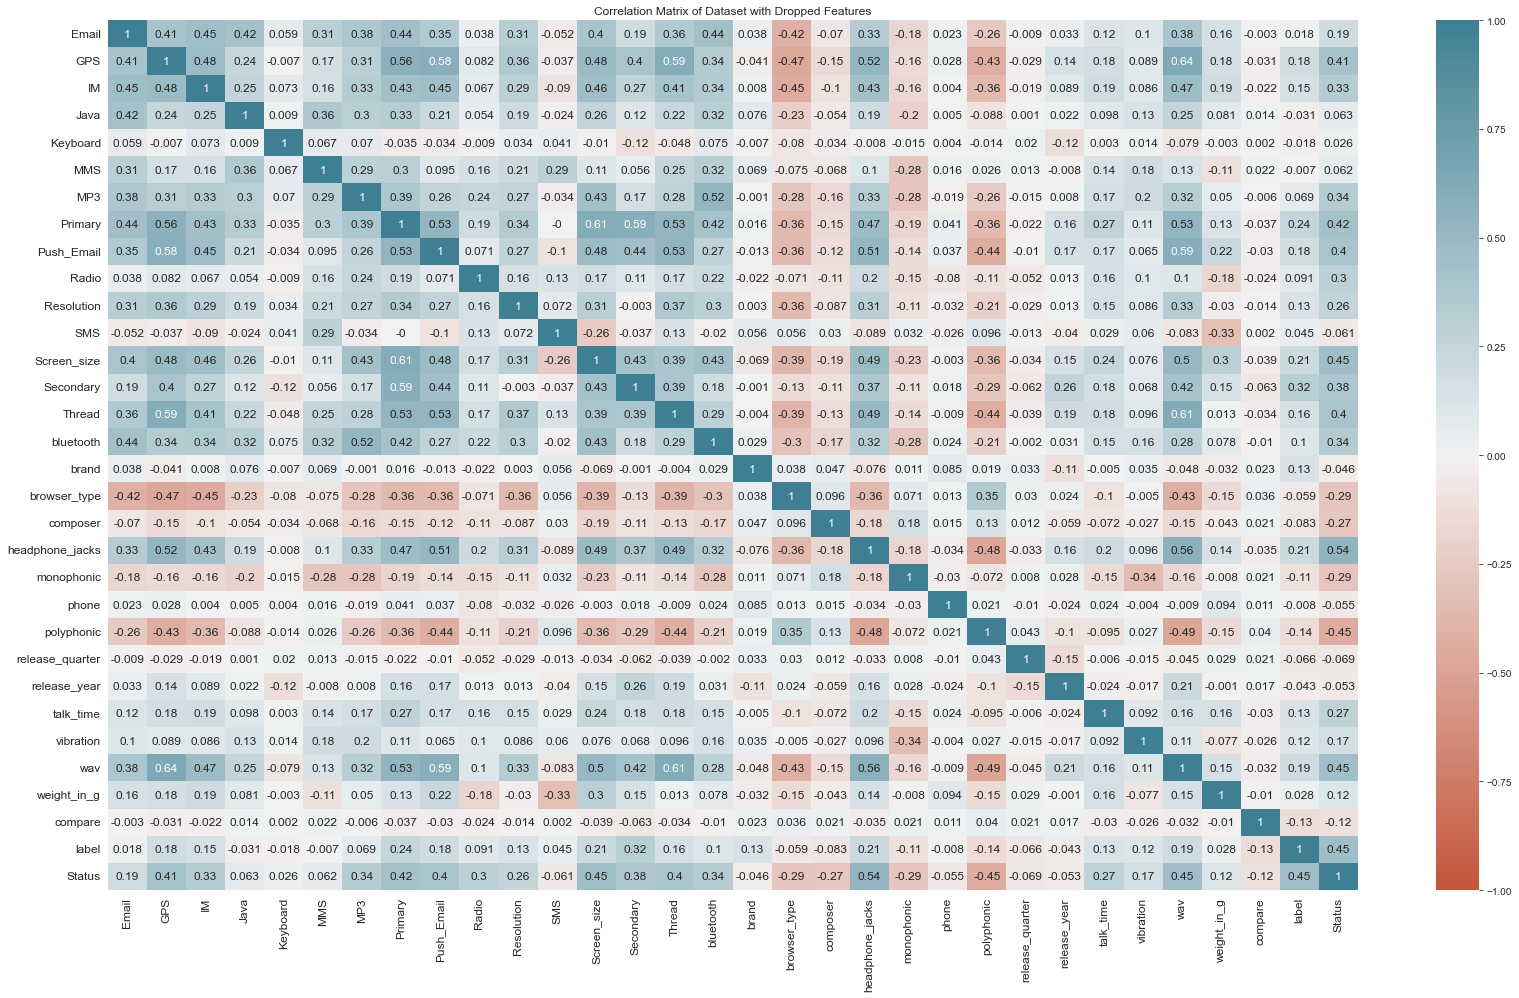

In [69]:
fig,ax = plt.subplots(1,1, figsize=(28,16))

sns.heatmap(dff.corr().round(3), vmin=-1, vmax=1,
            cmap=sns.diverging_palette(20, 220, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 12})

_y = plt.yticks(rotation=0, fontsize=12)
_x = plt.xticks(rotation=90, fontsize=12)

plt.title('Correlation Matrix of Dataset with Dropped Features')
plt.show()

#### Unfortunately, after all the work needed to synthesise data, the release and release_quarter have very little correlation on the target variable (Status). However, we would not have known, had we not filled the NaN values in the first place. It is always best to check, to maximise model accuracy.

In [70]:
dff = dff.drop(columns=['Keyboard','brand','label','phone','release_quarter','compare', 'release_year'])  # Correlations of < abs(0.1) are not used for model training
len(dff.columns)  # We therefore have 24 features that can be used to train the model

25

---

# **Section 12: Training Initial Models**

In [71]:
X = dff.drop('Status',axis = 1).values
y = dff['Status'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [72]:
models = []
models.append(SVC())

In [98]:
def test_models(model, X_train, y_train, y_test):
    
    results = []
    rnge = len(model)
    for i in range(0,rnge,1):
        
    
        std_clf = make_pipeline(StandardScaler(), PCA(n_components=24), model[i])
        std_clf.fit(X_train, y_train)
        y_pred = std_clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        print(model[i])
        print("Accuracy : ", accuracy)
        print('-----------------------------')
        
        results.append(y_pred)
        
    return results, accuracy

y = dff[['Status']].values.reshape(-1,)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [99]:
results = test_models(models, X_train, Y_train, Y_test)  # Results of training the initial models

SVC()
Accuracy :  0.9645411203814065
-----------------------------


---

# **Section 13: Final Model Evaluation**

As the SVC performed better than the RFC, we will use the SVC for our final model

In [100]:
std_clf = make_pipeline(StandardScaler(), PCA(n_components=24), SVC())  # Here we create a pipeline for our final model
std_clf.fit(X_train, Y_train)
y_pred = std_clf.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy : ", accuracy)

Accuracy :  0.9645411203814065


In [101]:
class_rep_t = classification_report(Y_test, y_pred, output_dict=True)  # This cell is tasked with formulating evaluation metrics
df_cr = pd.DataFrame(class_rep_t)
df_cr = df_cr.T

df_cr = df_cr.drop(labels='accuracy', axis=0)
acc_df = pd.DataFrame([['', '', '', '']], index=['accuracy'], columns=['precision', 'recall', 'f1-score', 'support'])

df_cr = df_cr.rename({ '0' : "Discontinued" ,
                       '1' : 'Available'}, axis=0)

crf = df_cr.round(2)
crf = pd.concat([crf, acc_df])

In [102]:
labels = ['Status=0','Status=1']
df_heatmap2 = pd.DataFrame(confusion_matrix(Y_test, y_pred), index=labels, columns=labels)

Accuracy of final SVC model:  0.9645411203814065 

Classification Report:


,precision,recall,f1-score,support
Discontinued,0.92,0.86,0.89,551.0
Available,0.97,0.98,0.98,2805.0
macro avg,0.94,0.92,0.93,3356.0
weighted avg,0.96,0.96,0.96,3356.0
accuracy,,,,



 Confusion Matrix:


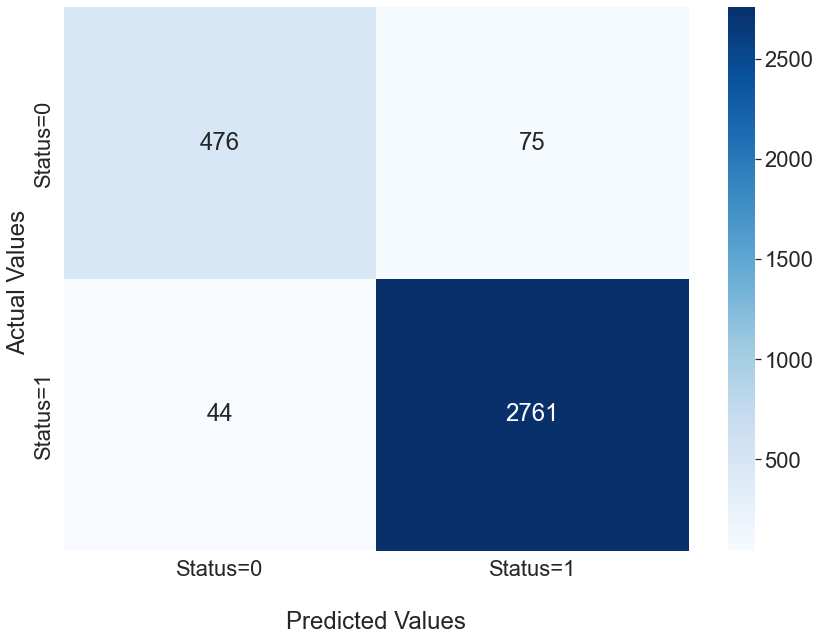

In [103]:
print("Accuracy of final SVC model: ", accuracy,'\n')

print('Classification Report:')
display(crf)
print('\n', 'Confusion Matrix:')

fig,ax = plt.subplots(1,1, figsize=(14,10))
sns.set(font_scale=2.0)

heatmap = sns.heatmap(df_heatmap2, annot=True, fmt="d", cmap='Blues')
heatmap.set_xlabel('\nPredicted Values')
heatmap.set_ylabel('Actual Values ')
plt.show()

---

# **Section 14: Conclusion and Results**

#### To conclude:
- I identified a significant proportion of NaN values
- I replaced NaN values using a rigorous process of training a machine learning algorithm create accurate synthetic data
- I further used the ML synthetic data to address the bias problem without, increasing dataset size instead of reducing.
- I used the final dataset, of no NaN values and no bias to training a machine learning model to classify the target variables 'Status' to a high degree of accuracy

#### Do I get the same results as Jennings page 7?:
- I achieved a greater accuracy than Jennings (assuming he used the same original dataset), through the use of:
    - Reducing bias in dataset using synthetic data
    - Reducing NaN values in dataset using synthetic data
- My model achieved an accuracy of: **96.5%**


In [104]:
print('My SVC model achieved an accuracy of', round(accuracy-0.9241,4)*100, '% greater than Jennings')

My SVC model achieved an accuracy of 4.04 % greater than Jennings


---